In [2]:
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
import nltk
import string
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score,hamming_loss
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

[nltk_data] Downloading package punkt to C:\Users\zxc
[nltk_data]     ghoul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
db_name = 'recipe.db'
conn = sqlite3.connect(db_name)

table_name = 'recipe'

#забираем доступные категории
categories_sql = f"select c.id, c.name_cat from category c " \
                 f"join recipe_categories rc on " \
                 f"c.id = rc.cat_id " \
                 f"GROUP by c.id " \
                 f"HAVING count(*) > 100 " \
                 f"ORDER BY c.id"

loaded_categories = pd.read_sql(categories_sql, conn)

ids_cat = []
for i in range(len(loaded_categories)):
    ids_cat.append(str(loaded_categories.id[i]))

#забираем способ приготовления рецепта с категориями из доступных с id категорий
sql = f"SELECT r.manual, (SELECT group_concat(rc.cat_id , ', ') " \
      f"from recipe_categories rc " \
      f"WHERE rc.recipe_id = r.id AND " \
      f"rc.cat_id in ({', '.join(ids_cat)})) " \
      f"AS categories from recipe r"

loaded_data = pd.read_sql(sql, conn)

#pandas data frame
conn.close()

In [5]:
loaded_data

,manual,categories
0,Шоколад разломать на кусочки и вместе со сливо...,"1, 2"
1,Положите весь творог в кастрюльку и разомните ...,"4, 5"
2,Вскипятите воду в большой кастрюле и сварите п...,"7, 8"
3,Разогреть духовку. Отделить белки от желтков. ...,"1, 5"
4,Взбить яйца с сахаром.\n\nПостепенно ввести му...,"1, 5, 14"
...,...,...
6990,"Печенку посолить, поперчить, посыпать специями...","30, 5"
6991,Крабовые палочки мелко нарезать или порубить в...,"17, 140"
6992,"Чечевицу промыть, залить водой на 4 см выше ур...",37
6993,Нарезать филе средними полосками. Морковь наре...,"17, 67, 139"


In [262]:
#print(loaded_categories.id)

ids_cat = []
for i in range(len(loaded_categories)):
    ids_cat.append(str(loaded_categories.id[i]))

print(ids_cat)

['1', '2', '4', '5', '7', '8', '14', '16', '17', '20', '25', '27', '30', '33', '37', '43', '51', '62', '67', '68', '71', '90', '99', '103', '105', '139', '140', '150', '158', '257']


In [6]:
for i in range(len(ids_cat)):
    val = []
    for j in range(len(loaded_data)):
        spl = str(loaded_data.categories[j]).split(', ')
        #print(spl)
        #print(int(str(ids_cat[i]) in spl))
        val.append(int(str(ids_cat[i]) in spl))
    loaded_data.insert(loc=len(loaded_data.columns) , column=ids_cat[i], value=val)
#print(val)

In [7]:
#делим dataset на тренировочный и тестовый
x_train,x_test,y_train,y_test = train_test_split(loaded_data["manual"], loaded_data[ids_cat],test_size=0.3,random_state=42)

In [8]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

In [9]:
example = loaded_data.iloc[1]["manual"]
print(example)
print("------------------------")
print(tokenize_sentence(example))

Положите весь творог в кастрюльку и разомните его вилкой так, чтобы в нем не осталось крупных комков. Разбейте в него яйца, всыпьте сахар и тщательно все перемешайте. Лучше не использовать слишком сухой или слишком влажный творог, иначе сырники будут разваливаться в процессе приготовления.

Всыпьте в творог 5 столовых ложек (с горкой) муки и тщательно перемешайте. Можно добавить немного больше муки, сырники получатся тогда более плотными. Или муки можно добавить чуть меньше, и тогда сырники будут нежнее. В итоге у вас должна получиться однородная масса, из которой можно будет лепить сырники.

Поставьте сковороду на средний огонь и налейте в нее подсолнечное масло.

Насыпьте на тарелку немного муки. Слепите несколько небольших шариков из получившейся творожной массы и положите их на тарелку. Лучше лепить разом 4–5 шариков — столько, сколько поместится одновременно на сковороду. Затем по очереди обкатывайте творожные шарики в муке, плющите их в небольшие лепешки (они не должны быть слишк

In [298]:
#hyperparams
# Определение гиперпараметров для каждого компонента модели
tfidf_params = {
    'vectorizer__tokenizer': [lambda x: tokenize_sentence(x, remove_stop_words=True)],
    'vectorizer__max_features': [500, 1000, 2000],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'vectorizer__use_idf': [True, False],
    # Другие гиперпараметры...
}
normalizer_params = {
    'normalizer__norm': ['l1', 'l2'],  # Тип нормализации (l2 - евклидова норма)
    # Другие гиперпараметры...
}

random_forest_params = {
    'model__estimator__n_estimators': [50, 100, 200],
    'model__estimator__max_depth': [None, 5, 10],
    'model__estimator__min_samples_split': [2, 5, 10],
    # Другие гиперпараметры...
}

In [10]:
tokenizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True), lowercase=True, max_features=768) #0.0995712243925679

Xfeatures = tokenizer.fit_transform(x_train).toarray()

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [11]:
Xfeatures

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.06048893],
       ...,
       [0.08245546, 0.15207994, 0.        , ..., 0.        , 0.03936304,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.1284134 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [209]:
'''binary_rel_clf = BinaryRelevance(MultinomialNB()) #our model
binary_rel_clf.fit(Xfeatures, y_train)
'''
#старая версия

'binary_rel_clf = BinaryRelevance(MultinomialNB()) #our model\nbinary_rel_clf.fit(Xfeatures, y_train)\n'

In [210]:
from imblearn.over_sampling import SMOTE

#sampler = MultilabelOverSampler()
#X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

In [211]:
#X_train_resampled, y_train_resampled = random_oversampling(x_train, y_train, ids_cat, ratio=2.0)

In [12]:
model_pipeline = Pipeline([
    ("vectorizer",  TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True), max_features=768)),
    ("normalizer", Normalizer()),
    ("model",  OneVsRestClassifier(RandomForestClassifier()))
]
)
model_pipeline.fit(x_train, y_train)
accuracy_score(y_test,model_pipeline.predict(x_test))

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.0995712243925679

In [273]:
test_text = x_test[17]
print(test_text)

print(loaded_categories)
print()

print(model_pipeline.predict([test_text]))

Мелко нарубить красный лук и чеснок и обжарить в глубоком сотейнике на сливочном масле. Сначала лук, а когда он станет мягким — чеснок. Чеснок жарится только до появления сильного аромата — не дольше. Пережаренный чеснок — горчит.

Дальше нужно высыпать в сотейник нарезанную мелкими кубиками мякоть тыквы и обжарить ее вместе с луком и чесноком, следя за тем, чтобы ничего не подгорело и постоянно помешивая всю компанию.

Как только тыква немного размягчится, что легко определить простым нажатием ложки, влить на сковороду бренди и жарить еще минут пять, пока алкоголь не выпарится.

Затем нужно залить содержимое сотейника куриным бульоном, добавить перец, соль, сахар и еще 5–7 минут поварить.

Получившуюся кашу разбить в блендере вместе с нежирными сливками, петрушкой (предварительно нарезав ее).
Подавать с обжаренными на сухой сковороде очищенными тыквенными семечками.


     id               name_cat
0     1      Выпечка и десерты
1     2     Американская кухня
2     4               Зав

In [272]:
model_pipeline.predict_proba([test_text])

array([[0.02      , 0.        , 0.        , 0.2       , 0.08      ,
        0.16      , 0.        , 0.02      , 0.46466667, 0.11      ,
        0.1       , 0.01      , 0.27      , 0.05      , 0.16      ,
        0.02      , 0.01      , 0.02      , 0.23      , 0.04      ,
        0.02      , 0.        , 0.        , 0.02      , 0.01      ,
        0.24      , 0.06      , 0.01      , 0.        , 0.        ]])

In [215]:
x_test

5118    Кабачок очистить от кожуры и порезать кольцами...
4104    На каждом каштане с его тупой стороны сделать ...
4350    Если блендер мощный, можно измельчить все ингр...
263     Выложить в форму болгарский перец, смазать его...
5403    Поместить все ингредиенты в блендер и взбить.\...
                              ...                        
3838    Лук мелко нарезать, обжарить. Добавить свиной ...
1630    Изюм замочить в роме на 2 часа. Грецкие орехи ...
4039    Разогрейте оливковое масло в глубокой сковород...
1881    Помыть, высушить яблоки. Тонко нарезать.\n\nВы...
5318    Для начала приготовить крем-батат. Нарезать ба...
Name: manual, Length: 2099, dtype: object

In [274]:
accuracy_score(y_test,model_pipeline.predict(x_test))

0.09861838970938543

In [275]:
precision_score(average='weighted', y_true=y_test, y_pred=model_pipeline.predict(x_test))

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.7267481856940256

In [276]:
recall_score(average='weighted', y_true=y_test, y_pred=model_pipeline.predict(x_test))

0.2329724853405503

In [277]:
y_score = model_pipeline.predict_proba(x_test)
print(y_score)

[[0.14 0.02 0.02 ... 0.01 0.   0.  ]
 [0.1  0.25 0.   ... 0.02 0.01 0.01]
 [0.48 0.02 0.02 ... 0.01 0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.01]
 [0.16 0.28 0.19 ... 0.06 0.01 0.  ]
 [0.2  0.29 0.   ... 0.02 0.05 0.07]]


In [220]:
y_test['1']

5118    0
4104    0
4350    1
263     0
5403    0
       ..
3838    0
1630    1
4039    0
1881    1
5318    0
Name: 1, Length: 2099, dtype: int64

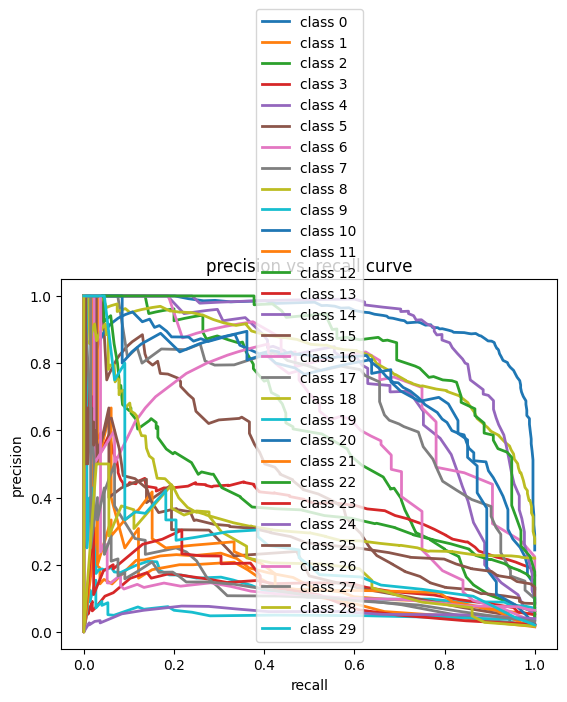

In [278]:
# precision recall curve
precision = dict()
recall = dict()
thresholds = dict()

for i in range(len(ids_cat)):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_true=y_test[ids_cat[i]],
                                                        probas_pred=y_score[:, i])

    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

In [279]:
probabilities = model_pipeline.predict_proba(x_test)
thresholds = 0.4  # Порог thresholds для каждого класса
predictions = np.zeros_like(probabilities)  # Массив для хранения предсказаний

for i in range(len(loaded_categories)):
    predictions[:, i] = (probabilities[:, i] > thresholds).astype(int)

In [280]:
predictions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [281]:
print(precision_score(average='weighted', y_true=y_test, y_pred=predictions), precision_score(average='weighted', y_true=y_test, y_pred=model_pipeline.predict(x_test)))
print(accuracy_score(y_test,predictions), accuracy_score(y_test,model_pipeline.predict(x_test)))
print(recall_score(average='weighted', y_true=y_test, y_pred=predictions), recall_score(average='weighted', y_true=y_test, y_pred=model_pipeline.predict(x_test)))

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6466415736687169 0.7267481856940256
0.13434969032872796 0.09861838970938543
0.32160577356788456 0.2329724853405503


In [282]:
#оценка гиперпараметров

random_search = RandomizedSearchCV(model_pipeline, param_distributions={
    **tfidf_params,
    **normalizer_params,
    **random_forest_params
}, scoring='f1', cv=5, n_iter=10)

random_search.fit(x_train, y_train)

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._s

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(max_features=768,
                                                              tokenizer=<function <lambda> at 0x00000263DF0A98B0>)),
                                             ('normalizer', Normalizer()),
                                             ('model',
                                              OneVsRestClassifier(estimator=RandomForestClassifier()))]),
                   param_distributions={'model__estimator__max_depth': [None, 5,
                                                                        10],
                                        'model__estimator__min_samples_split': [2,
                                                                                5,
                                                                                10],
                                        'model__estimator__n_estimators': [50,
                                                                           100,
                                                                           200],
                                        'normalizer__norm': ['l1', 'l2'],
                                        'vectorizer__max_features': [500, 1000,
                                                                     2000],
                                        'vectorizer__ngram_range': [(1, 1),
                                                                    (1, 2)],
                                        'vectorizer__use_idf': [True, False]},
                   scoring='f1')

In [284]:
best_params = random_search.best_params_
print(best_params)

best_model = random_search.best_estimator_

#y_pred = best_model.predict_prob(x_test)

{'vectorizer__use_idf': True, 'vectorizer__ngram_range': (1, 2), 'vectorizer__max_features': 2000, 'normalizer__norm': 'l1', 'model__estimator__n_estimators': 100, 'model__estimator__min_samples_split': 2, 'model__estimator__max_depth': 5}


In [299]:
# Получение наилучших параметров
best_tfidf_params = {
    'tokenizer': lambda x: tokenize_sentence(x, remove_stop_words=True),
    'max_features': 2000,
    'ngram_range': (1, 2),
    'use_idf': True,
    'smooth_idf': True,
    'sublinear_tf': True
}

best_normalizer_params = {
    'norm': 'l1'
}

best_random_forest_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'min_samples_split': 2
}

# Создание пайплайна модели с наилучшими параметрами
best_model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(**best_tfidf_params)),
    ("normalizer", Normalizer(**best_normalizer_params)),
    ("model", RandomForestClassifier(**best_random_forest_params))
])

# Обучение наилучшей модели на тренировочных данных
best_model_pipeline.fit(x_train, y_train)

# Оценка наилучшей модели на тестовых данных
y_pred = best_model_pipeline.predict(x_test)

C:\Users\zxc ghoul\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [300]:
accuracy_score

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [301]:
probabilities = best_model_pipeline.predict_proba(x_test)
thresholds = 0.4  # Порог thresholds для каждого класса
predictions = np.zeros_like(probabilities)  # Массив для хранения предсказаний

for i in range(len(loaded_categories)):
    predictions[:, i] = (probabilities[:, i] > thresholds).astype(int)

print(precision_score(average='weighted', y_true=y_test, y_pred=predictions), precision_score(average='weighted', y_true=y_test, y_pred=best_model_pipeline.predict(x_test)))
print(accuracy_score(y_test,predictions), accuracy_score(y_test,best_model_pipeline.predict(x_test)))
print(recall_score(average='weighted', y_true=y_test, y_pred=predictions), recall_score(average='weighted', y_true=y_test, y_pred=best_model_pipeline.predict(x_test)))

TypeError: list indices must be integers or slices, not tuple

In [305]:
recall_score(average='weighted', y_true=y_test, y_pred=best_model_pipeline.predict(x_test))

0.06089309878213803